In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import numpy as np
from numpy.fft import fft2, fftshift, fftfreq
import torch

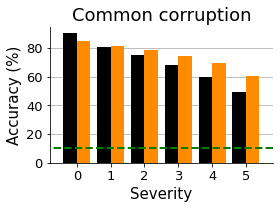

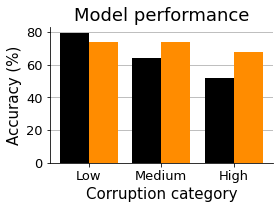

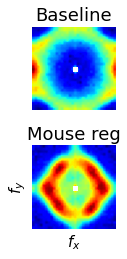

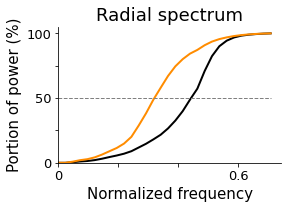

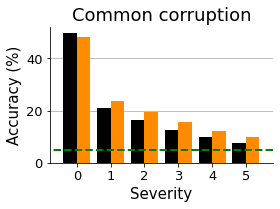

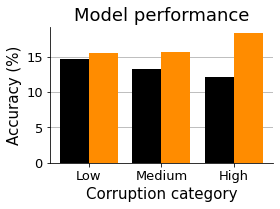

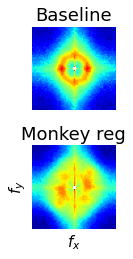

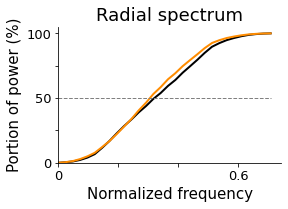

In [2]:
CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise',
    'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur',
    'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression',
]

for animal in ['mouse', 'monkey']:
    saved = torch.load(f'store/figs-data/{animal}_corruption.pt')
    colors = {
        'base': 'black',
        'neural': 'darkorange',
    }

    # fig 2a, c
    fig, ax = plt.subplots(figsize=(4, 2.5))
    xticks = np.arange(6)
    width = 0.4

    for i, label in enumerate(['base', 'neural']):
        accs = []
        for severity in range(6):
            if severity==0:
                accs.append(saved[label][0])
            else:
                accs.append(np.mean(saved[label][severity]))
        accs = np.array(accs)*100.
        ax.bar(xticks+(i-0.5)*width, accs, width=width, facecolor=colors[label], zorder=3)
    ax.set_xticks(xticks)
    ax.set_xlabel('Severity')
    if animal=='mouse':
        ax.set_yticks([0, 20, 40, 60, 80])
        base_acc = 10
    if animal=='monkey':
        ax.set_yticks([0, 20, 40])
        base_acc = 5
    ax.plot([-1, 6], base_acc*np.ones(2), color='green', linestyle='--', zorder=4)
    ax.set_xlim([-0.8, 5.8])
    ax.yaxis.grid()
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Common corruption')

    fig.savefig(f'store/figs/{animal}_corruption_robustness.svg')
    plt.show()
    
    
    # fig 3a, c
    fig, ax = plt.subplots(figsize=(4, 2.5))
    xticks = np.arange(3)
    width = 0.4

    for i, label in enumerate(['base', 'neural']):
        acc_low = np.mean([saved[label][severity][CORRUPTIONS.index(corruption)] for corruption in [
            'snow', 'frost', 'fog', 'brightness', 'contrast',
        ] for severity in range(1, 6)])
        acc_medium = np.mean([saved[label][severity][CORRUPTIONS.index(corruption)] for corruption in [
            'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur',
            'elastic_transform', 'pixelate', 'jpeg_compression',
        ] for severity in range(1, 6)])
        acc_high = np.mean([saved[label][severity][CORRUPTIONS.index(corruption)] for corruption in [
            'gaussian_noise', 'shot_noise', 'impulse_noise',
        ] for severity in range(1, 6)])
        accs = np.array([acc_low, acc_medium, acc_high])*100.
        ax.bar(xticks+(i-0.5)*width, accs, width=width, facecolor=colors[label], zorder=3)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['Low', 'Medium', 'High'])
    ax.set_xlabel('Corruption category')
    if animal=='mouse':
        ax.set_yticks([0, 20, 40, 60, 80])
    if animal=='monkey':
        ax.set_yticks([0, 5, 10, 15])
    ax.yaxis.grid()
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Model performance')
    
    fig.savefig(f'store/figs/{animal}_corruption_breakdown.svg')
    plt.show()

    saved = torch.load(f'store/figs-data/{animal}_advs.pt')
    fig, axes = plt.subplots(2, 1, figsize=(1.5, 4))
    for i, label in enumerate(['base', 'neural']):
        diffs = saved['advs'][label]-saved['imgs'][label]
        diffs = diffs-np.mean(diffs, axis=(2, 3), keepdims=True)
        powers = np.abs(fft2(diffs))**2
        powers[..., 0, 0] = np.nan
        powers = fftshift(np.log(powers.mean(axis=(0, 1))))

        ax = axes[i]
        ax.imshow(powers, cmap='jet')
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if label=='base':
            ax.set_title('Baseline')
        if label=='neural':
            if animal=='mouse':
                ax.set_title('Mouse reg')
            if animal=='monkey':
                ax.set_title('Monkey reg')
            ax.set_xlabel('$f_x$')
            ax.set_ylabel('$f_y$')
    fig.savefig(f'store/figs/{animal}_adv_fourier_maps.svg')
    plt.show()

    fx, fy = np.meshgrid(fftfreq(powers.shape[0]), fftfreq(powers.shape[1]))
    freqs = fftshift((fx**2+fy**2)**0.5)

    fig, ax = plt.subplots(figsize=(4, 2.5))
    alphas = np.linspace(0, freqs.max(), 30)
    for i, label in enumerate(['base', 'neural']):
        diffs = saved['advs'][label]-saved['imgs'][label]
        diffs = diffs-np.mean(diffs, axis=(2, 3), keepdims=True)
        powers = np.abs(fft2(diffs))**2
        powers[..., 0, 0] = np.nan
        powers = fftshift(powers.mean(axis=(0, 1)))

        ratios = []
        for alpha in alphas:
            mask = freqs<=alpha
            ratios.append(np.nansum(powers[mask])/np.nansum(powers))
        ax.plot(alphas, np.array(ratios)*100, color=colors[label])
    ax.plot([0, freqs.max()], [50, 50], linestyle='--', color='gray', linewidth=1)
    ax.set_xlim([0, None])
    ax.set_xticks([0, 0.2, 0.4, 0.6])
    ax.set_xticklabels(['0', None, None, '0.6'])
    ax.set_xlabel('Normalized frequency')
    ax.set_ylim([0, None])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(['0', None, '50', None, '100'])
    ax.set_ylabel('Portion of power (%)')
    ax.set_title('Radial spectrum')
    fig.savefig(f'store/figs/{animal}_adv_fourier_radial.svg')
    plt.show()